# Miscellaneous plots

This notebook is for various plots used in the article 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tmm.tmm_core import coh_tmm
from tqdm import tqdm

plt.rcParams.update({"font.size": 16})
# plt.rcParams['ps.fonttype'] = 42
plt.rcParams["pdf.fonttype"] = 42

## SU-8 dispersion

1.596411236350459


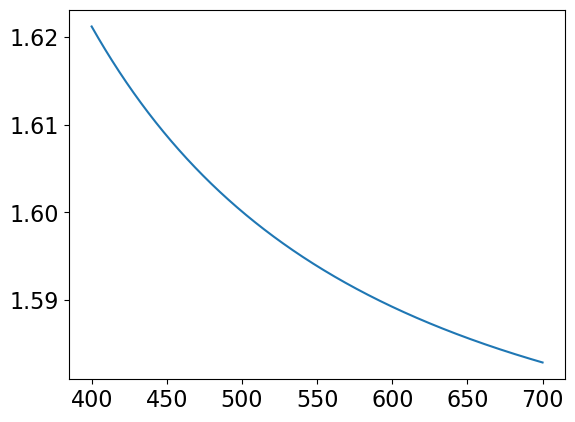

In [2]:
def cauchy(wl, A, B, C):
    return A + B / wl**2 + C / wl**4


wl = np.linspace(400, 700, 1000)
disp = cauchy(wl / 1000, 1.566, 0.00796, 0.00014)
plt.plot(wl, disp)

print(disp.mean())
plt.show()

## Profilometer measurement of synthetic cells

In [41]:
from scipy.signal import find_peaks

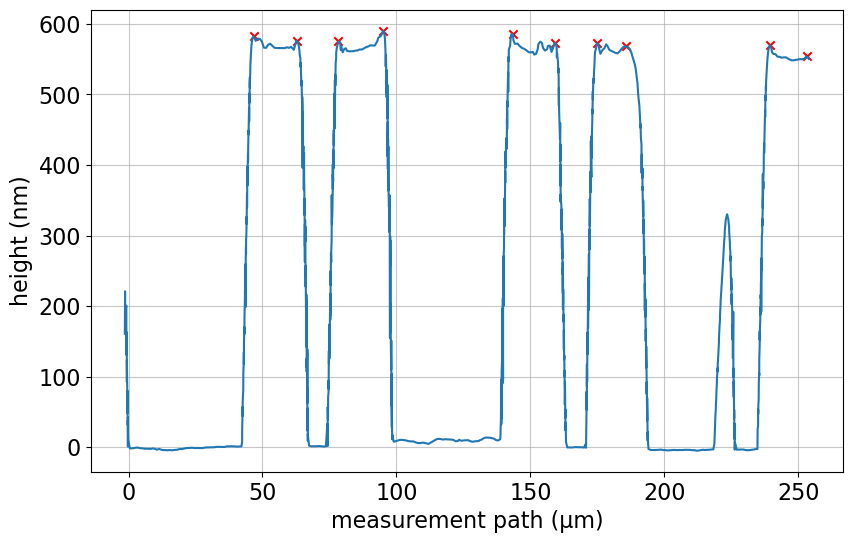

In [55]:
profile = np.loadtxt("fake_cells_profile.csv", delimiter=",")

height = profile[:, 1]
lenght = profile[:, 0]
peaks, _ = find_peaks(height, height=520, distance=16)

plt.figure(figsize=(1.618 * 6, 6))
plt.plot(profile[:, 0], profile[:, 1])
plt.scatter(lenght[peaks], height[peaks], marker="x", c="red")
plt.xlabel("measurement path (µm)")
plt.ylabel("height (nm)")
plt.grid(True, alpha=0.7)
plt.savefig("cal_cell_profile.pdf", bbox_inches="tight")

In [96]:
allheights = []
rawheights = []
for q in range(0, 8, 2):
    cellheight = height[peaks[q] : peaks[q + 1]]
    allheights.append(cellheight.mean())
    rawheights.append(cellheight)
    print(cellheight.mean(), cellheight.std())

allheights = np.array(allheights)
rawheights = np.array(np.concatenate(rawheights, axis=0))
print("\n", allheights.mean(), allheights.std())
print("\n Raw:", rawheights.mean(), rawheights.std())

# Lenghts

569.5343207140378 5.270030944059791
567.4736121264111 6.275951759095105
566.8463597411205 6.681075683495009
564.3744529114015 4.5497510020916705

 567.0571863732428 1.8405917286529616

 Raw: 567.2464942939483 6.108402699752662


## CMFS and reflection spectra

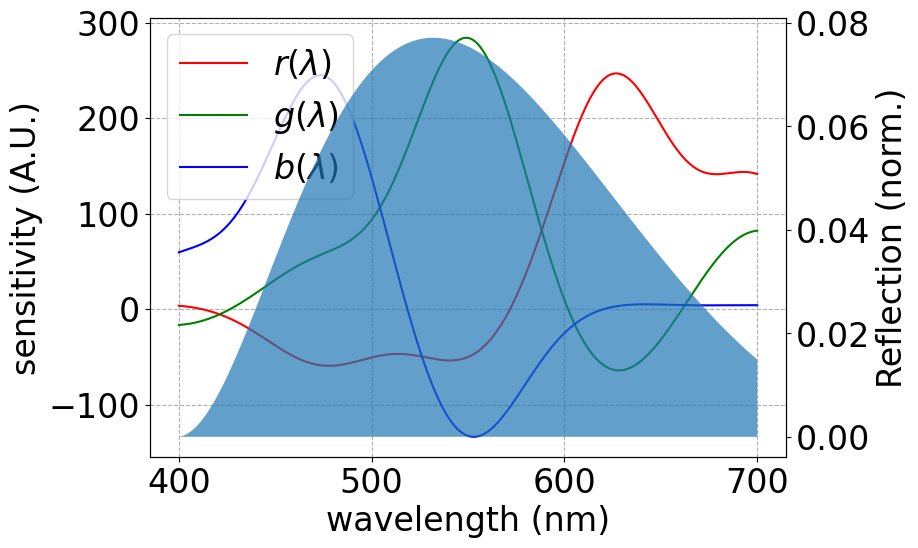

In [896]:
from tmm.tmm_core import coh_tmm


def get_ref_spectra_dlst_nlst(wavs, dlst, nlst):
    """Compute the reflection spectra for series of thin films of constant refractive
    index and thickness. Upper layer first, substrate last.

    Inputs
        wavs [array] - Vector of wavelengths in nm
        dlst [list] - list of film thicknesses [nm]
        nlst [list] - list of film refractive indeces (avg over wavs)
    Output
        coh_tmm reflection [array] - Reflection spectra"""

    reflection = np.empty(wavs.shape)  # Allocate reflection vector
    dlst = [np.inf] + dlst + [np.inf]  # Add empty space before and after layers
    nlst = [1] + nlst + [1]  # Add refractive indeces of empty space

    for q, wav in enumerate(wavs):  # Compute reflection for every wavelength
        reflection[q] = coh_tmm("s", nlst, dlst, 0, wav)["R"]
    return reflection


# ===============================#
# a solution that uses rectangles
def rect(x, y, w, h, c):
    ax = plt.gca()
    polygon = plt.Rectangle((x, y), w, h, color=c)
    ax.add_patch(polygon)


# a solution that uses trapezoids
def polygon(x1, y1, x2, y2, c):
    ax = plt.gca()
    polygon = plt.Polygon([(x1, y1), (x2, y2), (x2, 0), (x1, 0)], color=c, alpha=0.3)
    ax.add_patch(polygon)


def rainbow_fill(X, Y, cmap=plt.get_cmap("jet")):
    ax2.plot(X, Y, lw=0, alpha=0.6)  # Plot so the axes scale correctly

    dx = X[1] - X[0]
    N = float(X.size)

    for n, (x, y) in enumerate(zip(X, Y)):
        color = cmap(n / N)
        # uncomment to use rectangles
        # rect(x,0,dx,y,color)
        # uncomment to use trapezoids
        if n + 1 == N:
            continue
        polygon(x, y, X[n + 1], Y[n + 1], color)


# ===============================#

CMFs = r"./v3_CCD_CMFs_lu.npy"
CMFS = np.load(CMFs)
lams = CMFS[:, 0]
RCMF = CMFS[:, 1]
GCMF = CMFS[:, 2]
BCMF = CMFS[:, 3]
plt.rcParams.update({"font.size": 24})

plt.figure(figsize=(1.618 * 6, 6))
plt.plot(lams, RCMF, c="red", label="$r(\lambda)$")
plt.plot(lams, GCMF, c="green", label="$g(\lambda)$")
plt.plot(lams, BCMF, c="blue", label="$b(\lambda)$")
plt.xlabel("wavelength (nm)")
plt.ylabel("sensitivity (A.U.)")
# plt.title("Loaded CMFs: " + CMFs)
plt.legend()
plt.grid(True, linestyle="--")

ax1 = plt.gca()
ax2 = ax1.twinx()
# rainbow_fill(lams, get_ref_spectra_dlst_nlst(lams, [300], [1.33]))
ax2.fill_between(lams, get_ref_spectra_dlst_nlst(lams, [300], [1.33]), y2=0, alpha=0.7)
ax2.set_ylabel("Reflection (norm.)")
plt.tight_layout()
plt.savefig("CMFs_LU_spec.pdf", bbox_inches="tight")
plt.show()

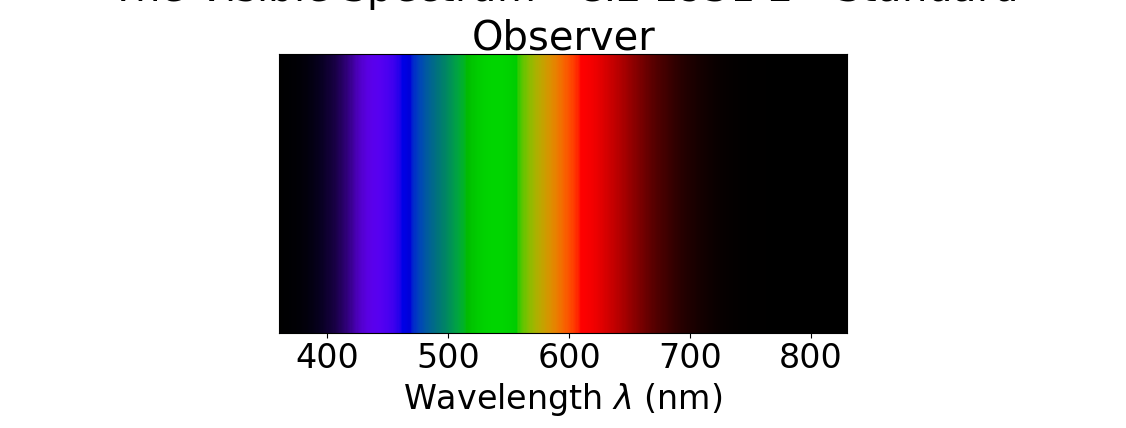

In [7]:
# dummy_spec=get_ref_spectra_dlst_nlst(lams, [300], [1.33])
# lams.shape
import colour

colour.plotting.plot_visible_spectrum(standalone=False)
plt.savefig("visible.pdf")

In [8]:
# Cell colors curve
import tmm.color
from tqdm import tqdm

plt.style.use("default")


# Define functions that return n for each wavelenght
n_air = lambda wavelength: 1
n_water = lambda wavelength: 1.33

# Define thickness and n list
n_fn_list = [n_air, n_water, n_air]
d_list = [np.inf, 500, np.inf]

# n vals
nvals = np.linspace(1.33, 1.55, 2000)
dvals = np.array([200, 400, 600, 800])
# dvals = np.array([200])


# Compute colors for thickness/n combinations
colorlist = []
xylist = []
XYZlist = []

for d in tqdm(dvals):
    for n in nvals:
        # Compute color of a single layer
        n_water = lambda wavelenght: n
        n_fn_list = [n_air, n_water, n_air]
        d_list = [np.inf, d, np.inf]
        reflectances = tmm.color.calc_reflectances(
            n_fn_list, d_list, th_0=0 * np.pi / 180, spectral_range="full"
        )
        result = tmm.color.calc_color(reflectances, scale=None, show_warnings=False)

        colorlist.append(result["irgb"])
        xylist.append(result["xy"])
        XYZlist.append(result["XYZ"])

colorlist = np.array(colorlist)
xylist = np.array(xylist)
XYZlist = np.array(XYZlist)

100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [12:00<00:00, 180.15s/it]


## CIE plot of thin fim chromaticities

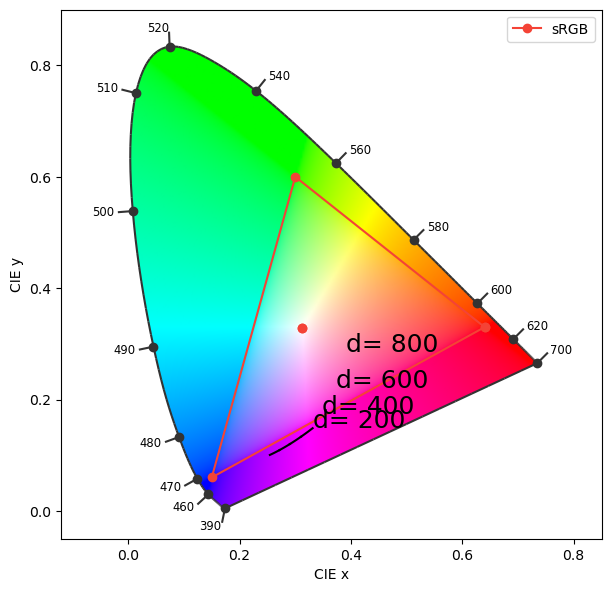

In [9]:
# fig, ax = colour.plotting.plot_chromaticity_diagram_CIE1931(standalone=False)
fig, ax = colour.plotting.plot_RGB_colourspaces_in_chromaticity_diagram_CIE1931(
    "sRGB", standalone=False
)

plt.rcParams.update({"font.size": 18})
plt.rcParams["pdf.fonttype"] = 42

# Check limits here
plt.plot(xylist[:100, 0], xylist[:100, 1], c="k")
plt.plot(xylist[100:200, 0], xylist[100:200, 1], c="k")
plt.plot(xylist[200:300, 0], xylist[200:300, 1], c="k")
plt.plot(xylist[300:400, 0], xylist[300:400, 1], c="k")

# ax.set_axis_off()
ax.set_xlim(-0.12, 0.85)
ax.set_ylim(-0.05, 0.9)
ax.set_title("")

# Annotate
count = 0
for k, xy in enumerate(xylist):
    # ax.annotate('{}'.format(k),xy)
    # Annotate each change of thickness
    if k % (xylist.shape[0] / dvals.size) == 0:
        # print(k)
        ax.annotate("d= {}".format(dvals[count]), xy)
        count += 1

# ax.set_axis_off()
plt.savefig("./other_plots/thin_film_cie.pdf", bbox_inches="tight")
plt.show()

## Plot of XYZ tristimulus values

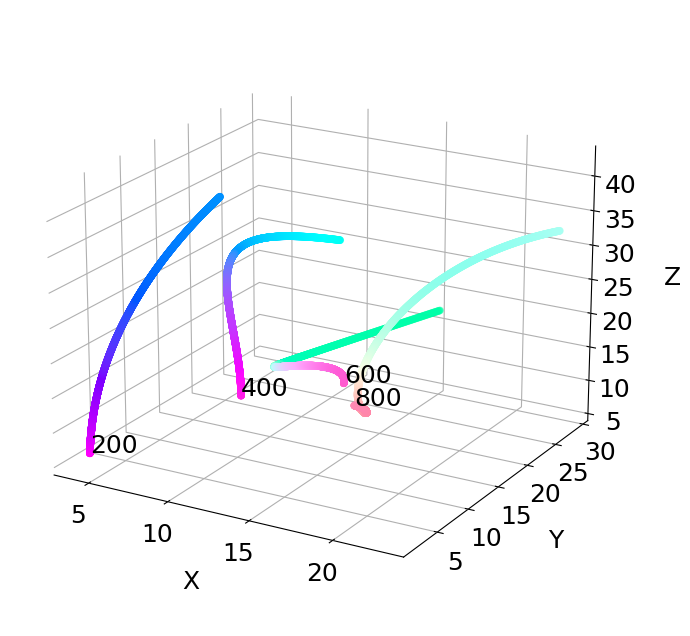

In [10]:
from mpl_toolkits.mplot3d import axes3d

plt.style.use("default")
plt.rcParams.update({"font.size": 18})
plt.rcParams["pdf.fonttype"] = 42

fig = plt.figure(figsize=(8 * 1.618, 8))
ax = fig.add_subplot(projection="3d", elev=20, azim=-60)
ax.scatter3D(XYZlist[:, 0], XYZlist[:, 1], XYZlist[:, 2], c=colorlist / 255, s=20)
# ax.scatter3D(XYZlist[:, 0], XYZlist[:, 1], XYZlist[:, 2],c='k')

ax.set_xlabel("X", labelpad=15)
ax.set_ylabel("Y", labelpad=15)
ax.set_zlabel("Z", labelpad=15)

ax.set_facecolor((0, 0, 0, 0))
ax.w_xaxis.set_pane_color((1, 1, 1, 0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.set_axis_off()

# Annotate
count = 0
for k, xyz in enumerate(XYZlist):
    # ax.annotate('{}'.format(k),xy)
    # Annotate each change of thickness
    if k % (XYZlist.shape[0] / dvals.size) == 0:
        # print(k)
        ax.text(xyz[0], xyz[1], xyz[2], dvals[count])
        count += 1

plt.savefig("./other_plots/thin_film_XYZ.pdf", bbox_inches="tight")

plt.show()

## Plot of RGB values (some values outside)

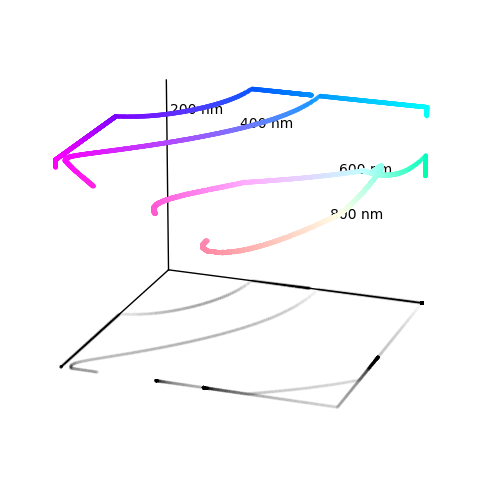

In [117]:
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure(figsize=(6 * 1.618, 6))
ax = fig.add_subplot(projection="3d", elev=20, azim=20)

# Main points
ax.scatter3D(
    colorlist[:, 0],
    colorlist[:, 1],
    colorlist[:, 2],
    c=colorlist / 255,
    s=5,
    rasterized=True,
)

# Shadows
ax.scatter(
    colorlist[:, 0],
    colorlist[:, 1],
    zs=0,
    zdir="z",
    c="k",
    alpha=0.01,
    s=3,
    rasterized=True,
)
# ax.scatter(colorlist[:, 1], colorlist[:, 2], zs=0, zdir='x', c='k',alpha=0.1,s=2)
# ax.scatter(colorlist[:, 0], colorlist[:, 2], zs=255, zdir='y', c='k',alpha=0.1,s=2)

# Line projections
# for color in colorlist[::20]:
#     ax.plot3D([color[0],color[0]],[color[1],color[1]],[0,color[2]],c='k',linewidth=1,alpha=0.3) # z=0
#     ax.plot3D([color[0],color[0]],[255,color[1]],[color[2],color[2]],c='k',linewidth=1,alpha=0.3) # y=0


ax.plot([0, 0], [0, 255], zs=0, zdir="z", c="k", linewidth=1, linestyle="-")
ax.plot([0, 255], [0, 0], zs=0, zdir="z", c="k", linewidth=1, linestyle="-")
ax.plot([0, 0], [0, 255], zs=0, zdir="x", c="k", linewidth=1, linestyle="-")


# ax.plot([0, 0], [0, 255], zs=255, zdir="z", c="k", linewidth=1, linestyle="-")
# ax.plot([0, 255], [0, 0], zs=255, zdir="z", c="k", linewidth=1, linestyle="-")
# ax.plot([0, 0], [0, 255], zs=255, zdir="x", c="k", linewidth=1, linestyle="-")

# ax.plot([255, 255], [0, 255], zs=255, zdir="z", c="k", linewidth=1, linestyle="-")
# ax.plot([255, 255], [0, 255], zs=0, zdir="z", c="k", linewidth=1, linestyle="-")

# ax.plot([0, 255], [255, 255], zs=0, zdir="z", c="k", linewidth=1, linestyle="-")
# ax.plot([0, 255], [255, 255], zs=255, zdir="z", c="k", linewidth=1, linestyle="-")

# ax.plot([255, 255], [0, 255], zs=255, zdir="x", c="k", linewidth=1, linestyle="-")
# ax.plot([0, 0], [0, 255], zs=255, zdir="y", c="k", linewidth=1, linestyle="-")


ax.set_axis_off()
ax.grid(False)
# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_zticks([])


# Annotate

ax.text(colorlist[1000, 0], colorlist[1000, 1], colorlist[1000, 2], "200 nm", size=10)
ax.text(colorlist[3000, 0], colorlist[3000, 1], colorlist[3000, 2], "400 nm", size=10)
ax.text(colorlist[5000, 0], colorlist[5000, 1], colorlist[5000, 2], "600 nm", size=10)
ax.text(colorlist[7000, 0], colorlist[7000, 1], colorlist[7000, 2], "800 nm", size=10)


# ax.plot3D(colorlist[:,0],colorlist[:,1],colorlist[:,2],c='k',linewidth=5)
ax.set_xlabel("R", labelpad=15)
ax.set_ylabel("G", labelpad=15)
ax.set_zlabel("B", labelpad=15)
ax.set_xlim(0, 255)
ax.set_ylim(0, 255)
ax.set_zlim(0, 255)
ax.set_facecolor((0, 0, 0, 0))
ax.w_xaxis.set_pane_color((0, 0, 0, 0))
ax.w_yaxis.set_pane_color((0, 0, 0, 0))
ax.w_zaxis.set_pane_color((0, 0, 0, 0))

# ax.invert_yaxis()

# plt.tight_layout()
plt.savefig("other_plots/RGB_thinfilm3D.pdf", bbox_inches="tight")
plt.show()

## Plot Pd sample reflection spectra

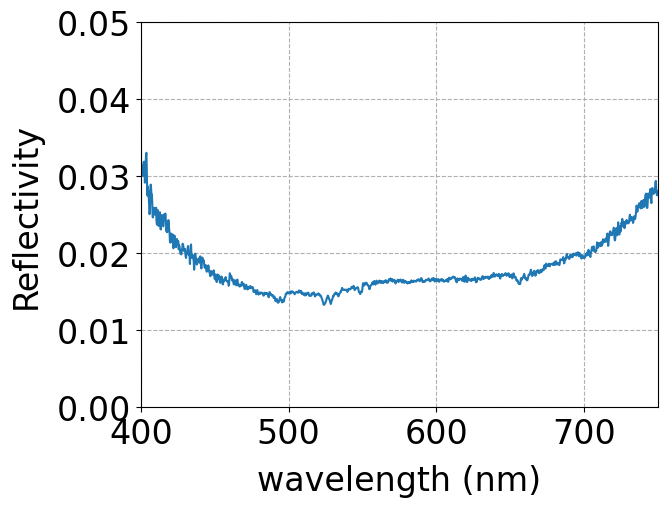

In [954]:
from matplotlib.ticker import MultipleLocator
from scipy.signal import savgol_filter

plt.rcParams.update({"font.size": 24})

# plt.style.use("dark_background")

spec = np.loadtxt(
    "../../True final samples/reflection_spectra/micro_Reflection_1.txt", skiprows=14
)
spec2 = np.loadtxt(
    "../../True final samples/reflection_spectra/sphere_Reflection_1.txt", skiprows=14
)

plt.figure(figsize=(4 / 3 * 5, 5))
plt.plot(spec[:, 0], savgol_filter(spec[:, 1], 5, 3) / 100, c="C0")
# plt.plot(spec[:, 0], spec[:, 1])

plt.ylim(0, 0.05)
plt.xlim(400, 750)
plt.grid(True, linestyle="--")
ax = plt.gca()
# ax.yaxis.set_major_locator(MultipleLocator(0.5))

plt.xlabel("wavelength (nm)", labelpad=10)
plt.ylabel("Reflectivity", labelpad=10)
# plt.tight_layout()

plt.savefig("Pd_reflection.pdf", bbox_inches="tight")
plt.show()

# Plot sensitivity graphs 

Plots of $\Delta n$ (refractive index resolution) vs camera bit changes 


Find the smallest difference in d and n that create a representable RGB value
note: Not possible to find a pair of d and n that gives RGB values between 0-1 naturally

d + 1e-6 gives the same color after 24 bit per channel rounding
n + 1e-9 gives the same color after 24 bit per channel discretization

Assuming initial values of d=500, n=1.4

## Define auxiliary functions

In [918]:
def bit_analysis_n(nlist, dlist, bitdepth):
    """Returns bitflip vs ∆n detectable curve data for a bitdepth
    Inputs:
        nlist - vector of n values
        dlist - vector of d values
        bitdepth - integet

    Outputs:
        bitflips - vector of bit changes
        dn_limits - vector of ∆n limit per bit
    """

    # Create bit variation vector
    bitflips = np.arange(10 + 1)

    # Create result dn vector
    dn_detectable = np.empty(bitflips.shape)

    # Create powers of 10 n increments vector
    n_incvec = 1 * 10 ** -(-1 + np.arange(10, dtype=float))

    # Test each bit variation
    for k, bitflip in enumerate(tqdm(bitflips)):

        # Initial worse ∆n per bitflip
        worsedn = 0

        # Across all combinations of n and d
        for n in nlist:
            for d in dlist:

                # Compute reference color
                colA = rgb_from_d_n(d, n)

                # Check each n+n_inc
                for dn in n_incvec:
                    # Compute color B for n+dn at constant d
                    colB = rgb_from_d_n(d, n + dn)
                    if all(colA == colB):
                        # Sanity check
                        # Stop if the 0-1 colors are the same to the computer
                        break
                    else:
                        # Obtain colors in discretized bit domain
                        colA_inbits = np.round(colA * 2**bitdepth)
                        colB_inbits = np.round(colB * 2**bitdepth)

                        # Test for tolerance in bits
                        # Maximum bit difference between discretized colors
                        bitdiff = np.abs(colA_inbits - colB_inbits).max()

                        # If bit difference is below bit depth then the colors
                        # cannot be differentiated. dn is the detection limit
                        # Check if current dn is worse than old dn, replace
                        # if true. That is the ∆n limit for the bitdepth
                        # across the thickness and n test range
                        if bitdiff <= bitflip and dn > worsedn:
                            worsedn = dn
        dn_detectable[k] = worsedn
    return dn_detectable


def bit_analysis_d(nlist, dlist, bitdepth):
    """Returns bitflip vs ∆n detectable curve data for a bitdepth
    Inputs:
        nlist - vector of n values
        dlist - vector of d values
        bitdepth - integet

    Outputs:
        bitflips - vector of bit changes
        dn_limits - vector of ∆n limit per bit
    """

    # Create bit variation vector
    bitflips = np.arange(10 + 1)

    # Create result dn vector
    dd_detectable = np.empty(bitflips.shape)

    # Create powers of 10 n increments vector
    d_incvec = 1 * 10 ** -(-1 + np.arange(10, dtype=float))

    # Test each bit variation
    for k, bitflip in enumerate(tqdm(bitflips)):

        # Initial worse ∆n per bitflip
        worsedd = 0

        # Across all combinations of n and d
        for n in nlist:
            for d in dlist:

                # Compute reference color
                colA = rgb_from_d_n(d, n)

                # Check each n+n_inc
                for dd in d_incvec:
                    # Compute color B for n+dn at constant n
                    colB = rgb_from_d_n(d + dd, n)
                    if all(colA == colB):
                        # Sanity check
                        # Stop if the 0-1 colors are the same to the computer
                        break
                    else:
                        # Obtain colors in discretized bit domain
                        colA_inbits = np.round(colA * 2**bitdepth)
                        colB_inbits = np.round(colB * 2**bitdepth)

                        # Test for tolerance in bits
                        # Maximum bit difference between discretized colors
                        bitdiff = np.abs(colA_inbits - colB_inbits).max()

                        # If bit difference is below bit depth then the colors
                        # cannot be differentiated. dn is the detection limit
                        # Check if current dn is worse than old dn, replace
                        # if true. That is the ∆n limit for the bitdepth
                        # across the thickness and n test range
                        if bitdiff <= bitflip and dd > worsedd:
                            worsedd = dd
        dd_detectable[k] = worsedd
    return dd_detectable

## Warning, this takes a long time for more than 25 points

In [923]:
from joblib import Parallel, delayed

dlist = np.linspace(300, 800, 40)
nlist = np.linspace(1.33, 1.55, 40)
print(
    "{} data points, d step: {} nm, n step: {}".format(
        dlist.size * dlist.size, dlist[1] - dlist[0], nlist[1] - nlist[0]
    )
)

bitdepths = [8, 12, 14, 16]

dnperdepth = Parallel(n_jobs=-1)(
    delayed(bit_analysis_n)(nlist, dlist, depth) for depth in bitdepths
)

1600 data points, d step: 12.820512820512818 nm, n step: 0.005641025641025532


100%|██████████| 11/11 [4:39:36<00:00, 1525.14s/it]

100%|██████████| 11/11 [4:58:06<00:00, 1626.04s/it]

## ∆n plot

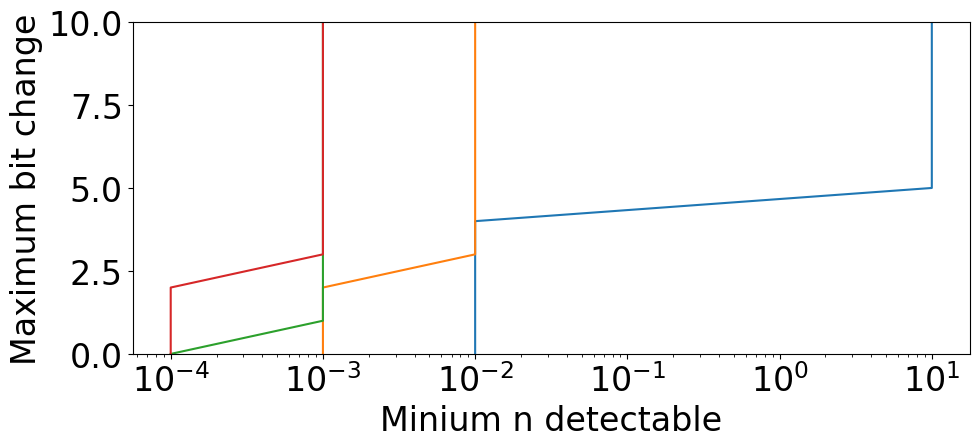

In [963]:
# Bit tolerance comparison for ∆n
bitflips = np.arange(10 + 1)

# Plot results
plt.figure(figsize=(6 / 3 * 5, 5))

# for k, depth in enumerate(bitdepths):
plt.semilogx(dnperdepth[0], bitflips, label="8 bits")
plt.semilogx(dnperdepth[1], bitflips, label="12 bits")
plt.semilogx(dnperdepth[2], bitflips, label="14 bits")
plt.semilogx(dnperdepth[3], bitflips, label="16 bits")

plt.xlabel("Minium n detectable")
plt.ylabel("Maximum bit change")
# plt.legend()
# plt.grid(which="minor", linestyle="--", alpha=0.7)
# plt.grid(which="major", linestyle="-", alpha=0.7)
plt.ylim(0, 10)
# plt.title("∆n resolution")

plt.tight_layout()
plt.savefig("other_plots/nresolutionc.pdf", bbox_inches="tight")
plt.show()

## ∆d computation

In [925]:
# dlist = np.linspace(300, 800, 2)
# nlist = np.linspace(1.33, 1.55, 2)
print(
    "{} data points, d step: {} nm, n step: {}".format(
        dlist.size * dlist.size, dlist[1] - dlist[0], nlist[1] - nlist[0]
    )
)

bitdepths = [8, 12, 14, 16]

ddperdepth = Parallel(n_jobs=-1)(
    delayed(bit_analysis_d)(nlist, dlist, depth) for depth in bitdepths
)

1600 data points, d step: 12.820512820512818 nm, n step: 0.005641025641025532



100%|██████████| 11/11 [5:09:55<00:00, 1690.49s/it]

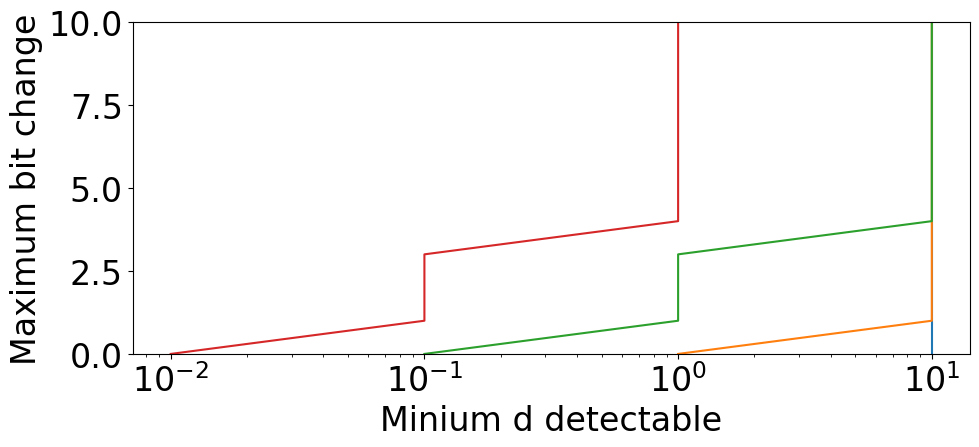

In [961]:
# Bit tolerance comparison for ∆n
bitflips = np.arange(10 + 1)

# Plot results
plt.figure(figsize=(6 / 3 * 5, 5))

# for k, depth in enumerate(bitdepths):
plt.semilogx(ddperdepth[0], bitflips, label="8 bits")
plt.semilogx(ddperdepth[1], bitflips, label="12 bits")
plt.semilogx(ddperdepth[2], bitflips, label="14 bits")
plt.semilogx(ddperdepth[3], bitflips, label="16 bits")

plt.xlabel("Minium d detectable")
plt.ylabel("Maximum bit change")
# plt.legend()
# plt.grid(which="minor", linestyle="--", alpha=0.7)
# plt.grid(which="major", linestyle="-", alpha=0.7)
plt.ylim(0, 10)
# plt.title("∆n resolution")

plt.tight_layout()
plt.savefig("other_plots/dresolutionc.pdf", bbox_inches="tight")
plt.show()

# Fake cell results

In [13]:
dimage = np.load("./Fake_cell_results2/Fake_cell_v4_LUT_dimage.npy")
nimage = np.load("./Fake_cell_results2/Fake_cell_v4_LUT_nimage.npy")

print(np.mean(np.abs(dimage - 574.2)))
print(np.mean(np.abs(nimage - 1.596)))

9.993321214528134
0.024339116650749806


# Clusters on real cell

In [72]:
import sys

sys.path.append("./src/")
import imageio
import photo_analysis_functions as src
from sklearn.cluster import KMeans

photo_file = r"./photo_data/cellB_LU_crop_1ms_ns.tif"
raw_photo = imageio.v2.imread(photo_file)  # Read the photo as 3D matrix of RGB values.


# Flatten image to a vector of RGB triplets
image_RGB_vector = raw_photo.reshape((-1, 3))

# Find cluster centers
clt = KMeans(n_clusters=50, verbose=False).fit(image_RGB_vector)

[162666.   5615.   4811.   8733.    747.   4334.   3569.   2342.   2289.
  10258.   3631.   7034.   4678.  30685.   4003.   2790.  19780.   1899.
   2162.   5031.   9865.   1237.   1738.   3149.   9393.   4065.   4106.
 115749.   2315.   6941.    739.   3387.  13263.   5803.   1062.   1701.
   4974.   3899.   2639.    636.   2581.   6065.   1096.   2989.   1370.
    865.   3864.   8559.   1231.   4615.] [ 0.    0.98  1.96  2.94  3.92  4.9   5.88  6.86  7.84  8.82  9.8  10.78
 11.76 12.74 13.72 14.7  15.68 16.66 17.64 18.62 19.6  20.58 21.56 22.54
 23.52 24.5  25.48 26.46 27.44 28.42 29.4  30.38 31.36 32.34 33.32 34.3
 35.28 36.26 37.24 38.22 39.2  40.18 41.16 42.14 43.12 44.1  45.08 46.06
 47.04 48.02 49.  ]


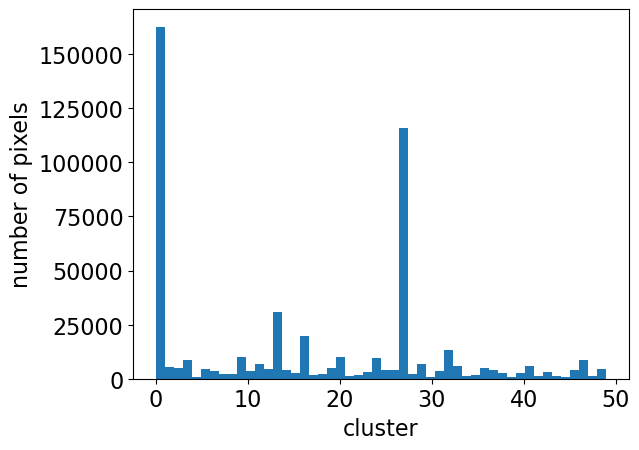

In [284]:
# Obtain size of each cluster using plt histogram function
n, bins, _ = plt.hist(clt.labels_, bins=50)
print(n,bins)
plt.xlabel("cluster")
plt.ylabel("number of pixels")
plt.show()

In [285]:
# order clusters acording to size
cluster_size_order = []
for q, val in enumerate(n):
    cluster_size_order.append(np.where(n == np.flip(np.sort(n))[q])[0][0])
print(cluster_size_order)

[0, 27, 13, 16, 32, 9, 20, 24, 3, 47, 11, 29, 41, 33, 1, 19, 36, 2, 12, 49, 5, 26, 25, 14, 37, 46, 10, 6, 31, 23, 43, 15, 38, 40, 7, 28, 8, 18, 17, 22, 35, 44, 21, 48, 42, 34, 45, 4, 30, 39]


In [382]:
labels = clt.labels_.copy()

bg_clusters = 3
# Remove background
for q, val in enumerate(cluster_size_order[:bg_clusters]):
    labels[labels == val] = 0

# Remove small clusters
nonzero_clusters=11
for q, val in enumerate(cluster_size_order[bg_clusters+nonzero_clusters:]):
    labels[labels == val] = 11

# Non-zero clusters:
print(np.unique(labels))

for q,label in enumerate(np.unique(labels)):
    labels[labels==label]=q
print(np.unique(labels))

recon_image = labels.reshape(raw_photo.shape[0], raw_photo.shape[1])

[ 0  3  9 11 16 20 24 29 32 33 41 47]
[ 0  1  2  3  4  5  6  7  8  9 10 11]


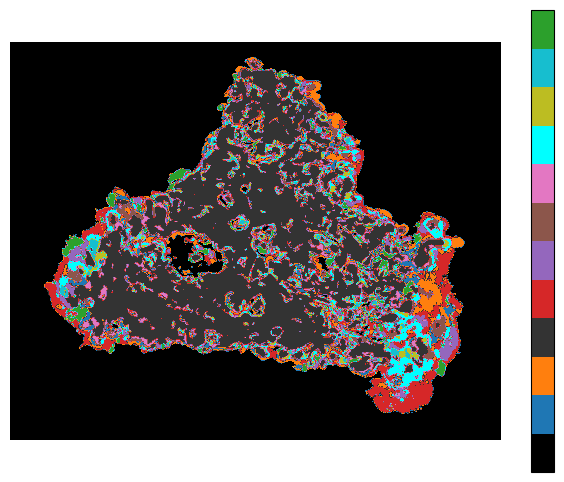

In [383]:
import matplotlib as mpl
colorlist=["k", "C0", "C1", .2*np.ones(3), "C3", "C4", "C5", "C6", "cyan","C8","C9","C2"]
mycmap = mpl.colors.ListedColormap(colorlist[:np.unique(labels).size])

plt.figure(figsize=(1.318*6,6))
plt.imshow(recon_image, cmap=mycmap)
# plt.imshow(recon_image, cmap=plt.cm.get_cmap('tab20',np.unique(labels).size))
plt.axis('off')
bar=plt.colorbar(ticks=[])
plt.savefig('./other_plots/{}_biggest_clusters.pdf'.format(nonzero_clusters),bbox_inches='tight',transparent=True)
plt.show()